In [73]:
import torch, yaml
import numpy as np
import matplotlib.pyplot as plt
import bsde.metrics

import importlib
importlib.reload(bsde.metrics)

from pathlib import Path

from bsde.solver import BSDESolver, DeepBSDESolverBS
from bsde.payoff import lookback_max, basket_call
from bsde.metrics import delta_hedge, dv_hedge ,delta_hedge_BS
from benchmark import MC_sim_BS


cfg = yaml.safe_load(Path("experiments/config.yaml").read_text())
cfg_heston = cfg["model"].copy()
cfg_heston.pop("d", None)

10

In [65]:
payoff_func = lambda S: lookback_max(S, strike=cfg["payoff"]["K"])
payoff_func_BS = lambda s: basket_call(s, strike=cfg["payoff"]["K"])

net_cfg = dict(hidden=128, depth=5)

In [66]:
solver = BSDESolver(
    model_params=cfg_heston,
    payoff_fn=payoff_func,
    T=cfg["T"],
    n_steps=cfg["n_steps"],
    net_cfg=dict(hidden=128, depth=4),
    lr=1e-4,
)

solver_BS = DeepBSDESolverBS(
    model_params=cfg["model"],
    payoff_fn=payoff_func_BS,
    T=cfg["T"],
    n_steps=cfg["n_steps"],
    net_cfg=net_cfg,
    lr=.5e-4,
)

In [67]:
solver.net.load_state_dict(torch.load("mod/bsde_lookback.pt",map_location="cpu"))
solver.net.eval()

solver_BS.net.load_state_dict(torch.load("mod/bsde_blackscholes.pt",map_location="cpu"))
solver_BS.net.eval()

FeedForwardNNBS(
  (fcn): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
  )
  (y_head): Linear(in_features=128, out_features=1, bias=True)
  (z_head): Linear(in_features=128, out_features=10, bias=True)
)

Y0 net  :, 0.15649397671222687, should be : MC Price = 0.13
Delta net :, 0.074599489569664, should be : << 1

payoff  mean : 0.1616666465997696
payoff  max  : 0.8327649831771851    payoff min : 0.0
cash0  mean  : 0.10221868753433228
pos0   mean  : 0.06030144542455673


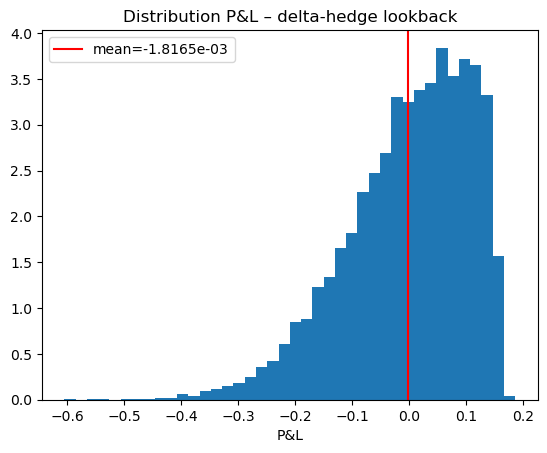

 mean  : -0.0018164985813200474
 stdev : 0.10885170847177505
moins


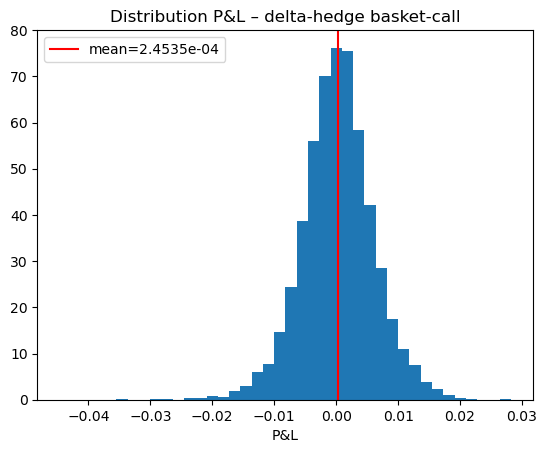

 mean  : 0.0002453488705214113
 stdev : 0.005835406947880983


In [68]:
pnl = delta_hedge(
    simulator =solver.simulator,
    net       = solver.net,      
    payoff_fn = payoff_func,
    n_paths   = 10_000,             
    n_steps   = cfg["n_steps"],
    T         = cfg["T"]
)

plt.hist(pnl, bins=40, density=True)
plt.axvline(pnl.mean(), color="r", label=f"mean={pnl.mean():.4e}")
plt.title("Distribution P&L – delta-hedge lookback")
plt.xlabel("P&L"); plt.legend(); plt.show()

print(" mean  :", pnl.mean().item())
print(" stdev :", pnl.std().item())

pnl_BS = delta_hedge_BS(
    simulator =solver_BS.simulator,
    net       = solver_BS.net,      
    payoff_fn = payoff_func_BS,
    n_paths   = 15_000,             
    n_steps   = cfg["n_steps"],
    T         = cfg["T"]
)

plt.hist(pnl_BS, bins=40, density=True)
plt.axvline(pnl_BS.mean(), color="r", label=f"mean={pnl_BS.mean():.4e}")
plt.title("Distribution P&L – delta-hedge basket-call")
plt.xlabel("P&L"); plt.legend(); plt.show()

print(" mean  :", pnl_BS.mean().item())
print(" stdev :", pnl_BS.std().item())

In [74]:
pnl_dv = dv_hedge(simulator=solver.simulator,
               net=solver.net,
               payoff_fn=payoff_func,
               n_paths=20_000,
               n_steps=cfg["n_steps"],
               T=cfg["T"])
print("Δ-only  σ ≈", pnl.std().item())
print("Δ+V     σ ≈", pnl_dv.std().item())

Δ-only  σ ≈ 0.10885170847177505
Δ+V     σ ≈ 0.08444096893072128


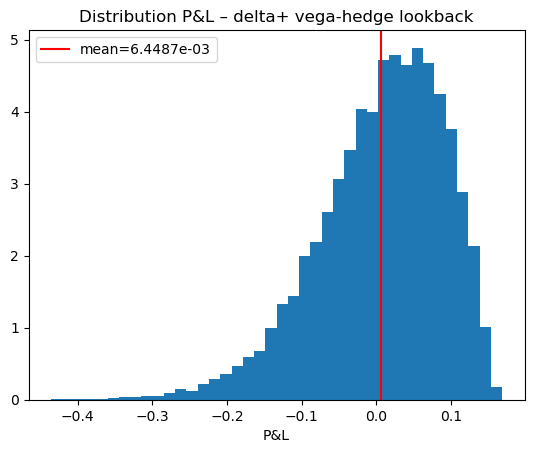

 mean  : 0.006448683328926563
 stdev : 0.08444096893072128


In [75]:
plt.hist(pnl_dv, bins=40, density=True)
plt.axvline(pnl_dv.mean(), color="r", label=f"mean={pnl_dv.mean():.4e}")
plt.title("Distribution P&L – delta+ vega-hedge lookback")
plt.xlabel("P&L"); plt.legend(); plt.show()

print(" mean  :", pnl_dv.mean().item())
print(" stdev :", pnl_dv.std().item())

### TEST TIME

In [76]:
import time

In [95]:
t0 = time.perf_counter()
price_mc, ci = MC_sim_BS(
    model      = solver_BS.simulator,     
    payoff_fn  = payoff_func_BS,
    n_paths    = 15_000,
    n_steps    = cfg["n_steps"],
    T          = cfg["T"],
    r          = 0.0,                     
)
mc_time = time.perf_counter() - t0

t0 = time.perf_counter()
with torch.no_grad():
    price_bsde = solver_BS.predict(n_paths=15_000)
net_time = time.perf_counter() - t0

In [96]:
print(f"Monte-Carlo : {mc_time:.2f} s   ->  price = {price_mc:.5f} ± {ci:.5f}")
print(f"BSDE Neural Network : {net_time:.2f} s   ->  price = {price_bsde:.5f}")
speedup = mc_time / net_time if net_time else float("inf")

Monte-Carlo : 0.27 s   ->  price = 0.07077 ± 0.00127
BSDE Neural Network : 2.50 s   ->  price = 0.07038
